Finding rouge scores for all the datasets with updated domination code

# Libraries and Installation

In [ ]:
import pandas as pd
import pickle
!pip install igraph
!pip install celluloid
import matplotlib.pyplot as plt
import networkx as nx
!pip install hypernetx
import hypernetx as hnx
import numpy as np
!pip install contractions
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
!pip install yake
!pip install rouge

     |████████████████████████████████| 3.2 MB 4.3 MB/s 
     |████████████████████████████████| 89 kB 3.5 MB/s 
     |████████████████████████████████| 284 kB 4.1 MB/s 
     |████████████████████████████████| 321 kB 57.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=208420895587c7611f310acf5e67ea7f78d07eb80209f7a715b6619ed38a45fa
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 60 kB 2.7 MB/s 
     |████████████████████████████████| 137 kB 8.6 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.8.9-cp37-cp37m-linux_x86_64.whl size=73236 sha256=454d60fb3be25daa5d5c39d43

# DUC Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# /content/gdrive/MyDrive/summarisation_dataset/duc_full_with_lsa.pkl

duc_df = pd.read_pickle('/content/gdrive/MyDrive/summarisation_dataset/duc_full_with_original_sum.pkl')
duc_df.head()

,story,filename,original_sents,clean_sents,clean_para,entities,keywords,combined_keywords,word_sentence_dictionary,dominating_set,hypo_summary,hypo_summary_para,summary,sumname,ref_summary_para,rouge_values,rouge-1 f scores,rouge-2 f scores,rouge-l f scores
0,"``Mad cow disease'' has killed 10,000 cattl...",doc-1.txt,"[ ``Mad cow disease has killed 10,000 catt...","[ Mad cow disease killed 10,000 cattle , restr...","Mad cow disease killed 10,000 cattle , restri...","[British, 1700s, february 9, Israel, Margaret ...","[BSE, disease, Britain, Agriculture, cattle, g...","[British, 1700s, february 9, report, Israel, M...",{'British': ['Ireland Department Agriculture F...,"[0, 3, 5, 10, 16, 17, 20, 22, 25]","[ ``Mad cow disease has killed 10,000 catt...","``Mad cow disease has killed 10,000 cattl...","""Mad cow disease"" (bovine spongiform encephalo...",summary-1-1.txt,"""Mad cow disease"" bovine spongiform encephalop...","{'rouge-1': {'r': 0.5333333333333333, 'p': 0.2...",0.357143,0.167742,0.330357
1,The UK will get strong backing from Brussels t...,doc-10.txt,[The UK will get strong backing from Brussels ...,[The UK get strong backing Brussels today Germ...,The UK get strong backing Brussels today Germa...,"[today, British, Bonn, two years, Brussels, Br...","[Germany, BSE, British, Commission, Bonn, ban,...","[British, today, exports, Bonn, live, two year...",{'British': ['The UK get strong backing Brusse...,"[1, 5, 9, 11]",[The European Commission planned to tell Germa...,The European Commission planned to tell German...,The European Commission will tell Germany toda...,summary-10-1.txt,The European Commission will tell Germany toda...,"{'rouge-1': {'r': 0.52, 'p': 0.475609756097560...",0.496815,0.211055,0.458599
2,\nIn a blow to California and other states wit...,doc-100.txt,[ In a blow to California and other states wit...,[In blow California states large immigrant pop...,In blow California states large immigrant popu...,"[Congress, Community Development Block Grant, ...","[Pulido, Census, illegal, California, county, ...","[190 years, James Gorman, City, illegal, Bush,...","{'190 years': ['For 190 years , said Sen .'], ...","[0, 1, 5, 9, 13, 16, 17, 20, 21, 23, 26, 31, 3...",[ In a blow to California and other states wit...,In a blow to California and other states with...,Illegal aliens will not be counted in the 1990...,summary-100-1.txt,Illegal aliens will not be counted in the 1990...,"{'rouge-1': {'r': 0.4794520547945205, 'p': 0.1...",0.246479,0.060606,0.239437
3,Three hours of steady rain Monday afternoon ...,doc-101.txt,[ Three hours of steady rain Monday afternoon...,[Three hours steady rain Monday afternoon prov...,Three hours steady rain Monday afternoon provi...,"[six, 920 acres, Monday afternoon, 1,100 acres...","[Monday, Forest, National, Park, Damron, Blued...","[six, 920 acres, Monday afternoon, 1,100 acres...",{'six': ['On ground firefighters aided six eng...,"[3, 5, 9, 14, 16]",[But the nearly quarter-inch of rain that fell...,But the nearly quarter-inch of rain that fell ...,Three hours of steady rain Monday provided a m...,summary-101-1.txt,Three hours of steady rain Monday provided a m...,"{'rouge-1': {'r': 0.5, 'p': 0.34375, 'f': 0.40...",0.407407,0.208145,0.395062
4,A lightning-sparked fire in Utah's Zion Nati...,doc-102.txt,[ A lightning-sparked fire in Utah s Zion Nat...,[ lightning-sparked fire Utah Zion National Pa...,lightning-sparked fire Utah Zion National Par...,"[18, Tennessee Division Forestry, 1,100 acres,...","[forest, National, fire, Tuesday, acres, fires...","[18, Tennessee Division Forestry, 1,100 acres,...",{'18': ['Kentucky Division Forestry reported 8...,"[5, 6, 8, 9, 10, 12, 18, 22, 23, 26, 27, 28, 3...",[Last night it sounded like every fire alarm i...,Last night it sounded like every fire alarm in...,A lightning-sparked fire in Utah's Zion Nation...,summary-102-1.txt,A lightning-sparked fire in Utah's Zion Nation...,"{'rouge-1': {'r': 0.43661971830985913, 'p': 0....",0.242187,0.058047

In [ ]:
duc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   story                     500 non-null    object 
 1   filename                  500 non-null    object 
 2   original_sents            500 non-null    object 
 3   clean_sents               500 non-null    object 
 4   clean_para                500 non-null    object 
 5   entities                  500 non-null    object 
 6   keywords                  500 non-null    object 
 7   combined_keywords         500 non-null    object 
 8   word_sentence_dictionary  500 non-null    object 
 9   dominating_set            500 non-null    object 
 10  hypo_summary              500 non-null    object 
 11  hypo_summary_para         500 non-null    object 
 12  summary                   500 non-null    object 
 13  sumname                   500 non-null    object 
 14  ref_summar

In [ ]:
# drop columns

duc_df = duc_df.drop(['word_sentence_dictionary', 'dominating_set', 'hypo_summary', 'hypo_summary_para', 'summary',  'rouge_values', 'rouge-1 f scores', 'rouge-2 f scores', 'rouge-l f scores'], axis = 1) 

In [ ]:
duc_df.head()

,story,filename,original_sents,clean_sents,clean_para,entities,keywords,combined_keywords,sumname,ref_summary_para
0,"``Mad cow disease'' has killed 10,000 cattl...",doc-1.txt,"[ ``Mad cow disease has killed 10,000 catt...","[ Mad cow disease killed 10,000 cattle , restr...","Mad cow disease killed 10,000 cattle , restri...","[British, 1700s, february 9, Israel, Margaret ...","[BSE, disease, Britain, Agriculture, cattle, g...","[British, 1700s, february 9, report, Israel, M...",summary-1-1.txt,"""Mad cow disease"" bovine spongiform encephalop..."
1,The UK will get strong backing from Brussels t...,doc-10.txt,[The UK will get strong backing from Brussels ...,[The UK get strong backing Brussels today Germ...,The UK get strong backing Brussels today Germa...,"[today, British, Bonn, two years, Brussels, Br...","[Germany, BSE, British, Commission, Bonn, ban,...","[British, today, exports, Bonn, live, two year...",summary-10-1.txt,The European Commission will tell Germany toda...
2,\nIn a blow to California and other states wit...,doc-100.txt,[ In a blow to California and other states wit...,[In blow California states large immigrant pop...,In blow California states large immigrant popu...,"[Congress, Community Development Block Grant, ...","[Pulido, Census, illegal, California, county, ...","[190 years, James Gorman, City, illegal, Bush,...",summary-100-1.txt,Illegal aliens will not be counted in the 1990...
3,Three hours of steady rain Monday afternoon ...,doc-101.txt,[ Three hours of steady rain Monday afternoon...,[Three hours steady rain Monday afternoon prov...,Three hours steady rain Monday afternoon provi...,"[six, 920 acres, Monday afternoon, 1,100 acres...","[Monday, Forest, National, Park, Damron, Blued...","[six, 920 acres, Monday afternoon, 1,100 acres...",summary-101-1.txt,Three hours of steady rain Monday provided a m...
4,A lightning-sparked fire in Utah's Zion Nati...,doc-102.txt,[ A lightning-sparked fire in Utah s Zion Nat...,[ lightning-sparked fire Utah Zion National Pa...,lightning-sparked fire Utah Zion National Par...,"[18, Tennessee Division Forestry, 1,100 acres,...","[forest, National, fire, Tuesday, acres, fires...","[18, Tennessee Division Forestry, 1,100 acres,...",summary-102-1.txt,A lightning-sparked fire in Utah's Zion Nation...


# Functions

In [ ]:
# find clean sentence dictionary 

def find_clean_sent_dict(cleaned_sentences):
  cleansent_dict = {}
  for i in range(len(cleaned_sentences)):
    cleansent_dict[i] = cleaned_sentences[i]
  return cleansent_dict

In [ ]:
# create dictionary 
import re

def create_hypergraph(updated_keyword_arr, cleaned_sentences, reverse_cleansent):
  word_sentence_dictionary = dict()
  for word in updated_keyword_arr:
    sentences_with_word = []
    for sentence in cleaned_sentences:
      result = re.findall('\\b'+word+'[\.|\s]',sentence) 
      if len(result) > 0:
        sentences_with_word.append(reverse_cleansent[sentence])
    word_sentence_dictionary[word] = sentences_with_word
  return word_sentence_dictionary

In [ ]:
# find the number of sentences in every key value pair of the dictionary, arrange them in ascending order, remove top 2

n = 2  # number of edges to be removed 
f = 5  # freq of high freq words 

def remove_high_freq_edges(word_sent_dict):
  freq_dict = dict()  # word : no of sentences in its list 
  for i in word_sent_dict:
    freq_dict[i] = len(word_sent_dict[i])

  freq_dict_list = list(freq_dict.items())  # convert dictionary to a list of tuples
  freq_dict_list.sort(key = lambda x : x[1]) # sort a/c to the second values in the tuple or frequency

  # remove last 'n' entries if freq > 'f'
  for i in range(n):
    if(freq_dict_list[-1][1] > f):
      word_sent_dict.pop(freq_dict_list[-1][0])
      freq_dict_list.pop()

  return word_sent_dict

In [ ]:
# function to find the set in the list of dominating sets with maximum number of elements
# return the first list with maximum number of elements

def find_list_with_max_elements(dom_list):
  no_of_elements = []  # find number of elements in every set 
  for i in range(len(dom_list)):
    no_of_elements.append(len(dom_list[i]))  # length of every dominating set
  max_ele = max(no_of_elements)

  for i in range(len(dom_list)):
    if len(dom_list[i]) == max_ele:
      return i 

In [ ]:
# list of dominating set (original sentences) go in the 'story' column
# original sentence in the story should be added in the summary 


def domination_row(keyword_sent_dict):
  # finding neighbors
  h = hnx.Hypergraph(keyword_sent_dict)
  li = []
  for i in list(h.nodes):
      li.append(h.neighbors(i))

  # Mapping nodes to numbers
  mapp = {}
  c = 0
  for i in list(h.nodes):
      mapp[i] = c
      c = c + 1

  # GFG code
  # s = []
  ver = len(li)
  # visit = np.zeros(ver)

  deg = {}
  for i in range(len(li)):
      deg[i] = len(li[i])

  deg = dict(sorted(deg.items(), key = lambda item: item[1], reverse = True))

  dom_li = []

  for di in range(ver):
    visit = np.zeros(ver)
    s = []
    
    k = list(deg.keys())[0]
    v = list(deg.values())[0]
    for i in deg.keys():
        if(visit[i] == 0):
            s.append(i)
            visit[i]=1
            for j in range(len(li[i])):
                if(visit[mapp[li[i][j]]]==0):
                    visit[mapp[li[i][j]]]=1
    deg.pop(list(deg.keys())[0])
    deg[k] = v
    dom_li.append(s)

  return sorted(dom_li[find_list_with_max_elements(dom_li)]), mapp  # returns the dominating set with the maximum elements

In [ ]:
# Deleting empty lists from the dictionary

def remove_keywords_with_empty_lists(word_sent_dict):
  copy_dict = word_sent_dict.copy()
  for i in copy_dict:
    if copy_dict[i] == []:
      word_sent_dict.pop(i)
  return word_sent_dict

In [ ]:
import spacy
from spacy import displacy
NER = spacy.load("en_core_web_sm")  # nlp 

def find_entities(cleaned_para):
  text1= NER(cleaned_para)
  entities = []
  for word in text1.ents:
    entities.append(word.text)
  l = set(entities) # remove duplicates
  l = list(l)  # list type
  return l

In [ ]:
import yake

language = "en"
max_ngram_size = 1  # 3/4 
deduplication_thresold = 0.8
deduplication_algo = 'seqm'
windowSize = 5
numOfKeywords = 20

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)

def find_keywords(cleaned_para):
  keywords = custom_kw_extractor.extract_keywords(cleaned_para)
  keyword_list = [keywords[x][0] for x in range(len(keywords))]

  return keyword_list


# DUC 2002

In [ ]:
# find clean_sent dict
# key = index of sent(int), value = sentence(str)

duc_df['clean_sent_dict'] = duc_df['clean_sents'].apply(find_clean_sent_dict)

In [ ]:
# reverse this dictionary

duc_df['reverse_cleanset'] = duc_df['clean_sent_dict'].apply(lambda x: {v:k for k,v in x.items()})

In [ ]:
# create word sentence dictionaries

duc_df['word_sentence_dictionary'] = duc_df.apply(lambda x: create_hypergraph(x.combined_keywords ,x.clean_sents, x.reverse_cleanset), axis = 1)

In [ ]:
# remove high frequency words from the dictionary 

duc_df['word_sentence_dictionary'] = duc_df['word_sentence_dictionary'].apply(remove_high_freq_edges)

In [ ]:
# remove keywords with empty lists from the dictionary

duc_df['word_sentence_dictionary'] = duc_df['word_sentence_dictionary'].apply(remove_keywords_with_empty_lists)

In [ ]:
# apply domination and return mapp dictionary 

# duc_df[['dominating_set', 'mapp_dict']] = duc_df.apply(lambda x: domination_row(x.word_sentence_dictionary), axis=1)

duc_df['dominating_set'], duc_df['mapp_dict'] = zip(*duc_df['word_sentence_dictionary'].apply(domination_row))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# find reverse of mapp dict 

duc_df['reverse_mapp'] = duc_df['mapp_dict'].apply(lambda x: {v:k for k,v in x.items()})

In [ ]:
# find indices of sentences from the nodes in dominating list 

duc_df['summary_sentences_indices'] = duc_df.apply((lambda x: [x.reverse_mapp[i] for i in x.dominating_set]), axis=1)

In [ ]:
# find system summary 

duc_df['hypo_summary'] = duc_df.apply((lambda x: [x.original_sents[i] for i in x.summary_sentences_indices]), axis=1)

In [ ]:
# convert all hypothesized summaries into paragraphs 

duc_df['hypo_summary_para'] = duc_df['hypo_summary'].apply(lambda x: " ".join([str(w) for w in x]))

In [ ]:
duc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   story                      500 non-null    object
 1   filename                   500 non-null    object
 2   original_sents             500 non-null    object
 3   clean_sents                500 non-null    object
 4   clean_para                 500 non-null    object
 5   entities                   500 non-null    object
 6   keywords                   500 non-null    object
 7   combined_keywords          500 non-null    object
 8   sumname                    500 non-null    object
 9   ref_summary_para           500 non-null    object
 10  clean_sent_dict            500 non-null    object
 11  reverse_cleanset           500 non-null    object
 12  word_sentence_dictionary   500 non-null    object
 13  dominating_set             500 non-null    object
 14  mapp_dict 

In [ ]:
duc_df['ref_summary_para'][0]

'"Mad cow disease" bovine spongiform encephalopathy or BSE has killed 10,000 cattle, restricted the export market for British beef and raised doubts about the safety of eating beef. Although the British government insists that the incurable disease poses only a remote risk to human health, scientists are not sure what causes the disease or how it is transmitted. It has symptoms similar to scrapie, a disease long observed in sheep, eating holes in the brains of its victims and in its late stages causing an animal to stagger drunkenly.  There are two human forms of spongiform encephalopathy: Creutzfeldt- Jakob disease and kuru.'

In [ ]:
duc_df['hypo_summary_para'][0]

'Ireland s Department of Agriculture and Food said about 20 cases have been confirmed there, all of them near the border with the British province of Northern Ireland. The symptoms are very much like scrapie, a sheep disease which has been in Britain since the 1700s. The Southwood report said it was ``most unlikely   that the disease was a threat to humans. There is a human variant of spongiform encephalopathy, known as Creutzfeldt-Jakob disease. The disease struck one of his own cows, Gourlay said. ``In the course of 24 hours, the animal went from being ostensibly quite normal to very vicious and totally disoriented. The government insists the disease poses only a remote risk to human health, but scientists still aren t certain what causes the disease or how it is transmitted.    ``I think everyone agrees that the risks are low,   says Martin Raff, a neurobiologist at University College, London. ``But they certainly are not zero. Mad cow disease, or bovine spongiform encephalopathy, o

In [ ]:
from rouge import Rouge

rouge = Rouge()

duc_df['rouge_values'] = duc_df.apply((lambda x: rouge.get_scores((x.hypo_summary_para).lower(), (x.ref_summary_para).lower() ,avg=True)), axis = 1)

In [ ]:
# avg of all rouge-1 f scores 

duc_df['rouge-1 f scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-1']['f'])
duc_df['rouge-1 f scores'].mean()

0.298958969819007

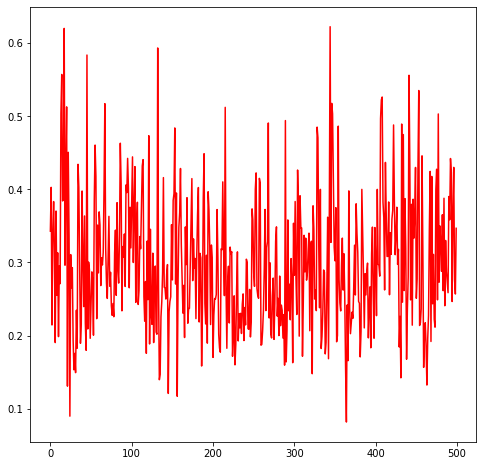

In [ ]:
import matplotlib.pyplot as plt
plt.plot(duc_df['rouge-1 f scores'],  color ="red")

In [ ]:
duc_df['rouge-1 f scores'].max()

0.6225165513547652

In [ ]:
duc_df['rouge-1 f scores'].min()

0.08179958869693593

In [ ]:
# rouge 2 f1 scores

duc_df['rouge-2 f scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-2']['f'])
duc_df['rouge-2 f scores'].mean()

0.10753904379325141

In [ ]:
duc_df['rouge-2 f scores'].max()

0.4858757012723037

In [ ]:
duc_df['rouge-2 f scores'].min()

0.0

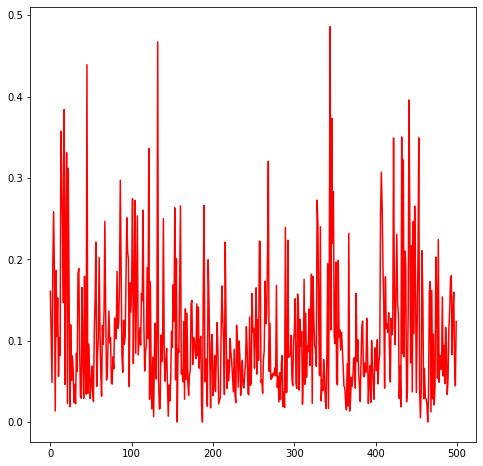

In [ ]:
import matplotlib.pyplot as plt
plt.plot(duc_df['rouge-2 f scores'],  color ="red")

In [ ]:
# rouge l f1 scores

duc_df['rouge-l f scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-l']['f'])
duc_df['rouge-l f scores'].mean()

0.27212566312615616

In [ ]:
duc_df.to_pickle('duc_full_updated_domination.pkl')

In [ ]:
duc_df['hypo_summary_para'][0]

'Ireland s Department of Agriculture and Food said about 20 cases have been confirmed there, all of them near the border with the British province of Northern Ireland. The symptoms are very much like scrapie, a sheep disease which has been in Britain since the 1700s. The Southwood report said it was ``most unlikely   that the disease was a threat to humans. There is a human variant of spongiform encephalopathy, known as Creutzfeldt-Jakob disease. The disease struck one of his own cows, Gourlay said. ``In the course of 24 hours, the animal went from being ostensibly quite normal to very vicious and totally disoriented. The government insists the disease poses only a remote risk to human health, but scientists still aren t certain what causes the disease or how it is transmitted.    ``I think everyone agrees that the risks are low,   says Martin Raff, a neurobiologist at University College, London. ``But they certainly are not zero. Mad cow disease, or bovine spongiform encephalopathy, o

In [ ]:
duc_df['ref_summary_para'][0]

'"Mad cow disease" bovine spongiform encephalopathy or BSE has killed 10,000 cattle, restricted the export market for British beef and raised doubts about the safety of eating beef. Although the British government insists that the incurable disease poses only a remote risk to human health, scientists are not sure what causes the disease or how it is transmitted. It has symptoms similar to scrapie, a disease long observed in sheep, eating holes in the brains of its victims and in its late stages causing an animal to stagger drunkenly.  There are two human forms of spongiform encephalopathy: Creutzfeldt- Jakob disease and kuru.'

In [ ]:
duc_df['dominating_set'][0]

[0, 3, 5, 10, 16, 17, 20, 22, 25]

In [ ]:
duc_df['hypo_summary'][0]

['Ireland s Department of Agriculture and Food said about 20 cases have been confirmed there, all of them near the border with the British province of Northern Ireland.',
 'The symptoms are very much like scrapie, a sheep disease which has been in Britain since the 1700s.',
 'The Southwood report said it was ``most unlikely   that the disease was a threat to humans.',
 'There is a human variant of spongiform encephalopathy, known as Creutzfeldt-Jakob disease.',
 'The disease struck one of his own cows, Gourlay said. ``In the course of 24 hours, the animal went from being ostensibly quite normal to very vicious and totally disoriented.',
 'The government insists the disease poses only a remote risk to human health, but scientists still aren t certain what causes the disease or how it is transmitted.    ``I think everyone agrees that the risks are low,   says Martin Raff, a neurobiologist at University College, London. ``But they certainly are not zero.',
 'Mad cow disease, or bovine spo

In [ ]:
import pickle 
import pandas as pd

duc_df = pd.read_pickle("/content/gdrive/MyDrive/summarisation_dataset/final_dataframes/duc_full_updated_domination.pkl")

In [ ]:
duc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   story                      500 non-null    object 
 1   filename                   500 non-null    object 
 2   original_sents             500 non-null    object 
 3   clean_sents                500 non-null    object 
 4   clean_para                 500 non-null    object 
 5   entities                   500 non-null    object 
 6   keywords                   500 non-null    object 
 7   combined_keywords          500 non-null    object 
 8   sumname                    500 non-null    object 
 9   ref_summary_para           500 non-null    object 
 10  clean_sent_dict            500 non-null    object 
 11  reverse_cleanset           500 non-null    object 
 12  word_sentence_dictionary   500 non-null    object 
 13  dominating_set             500 non-null    object 

In [ ]:
duc_df['rouge_values'][0]

{'rouge-1': {'f': 0.3428571382653062, 'p': 0.26666666666666666, 'r': 0.48},
 'rouge-2': {'f': 0.1608391562704779,
  'p': 0.12432432432432433,
  'r': 0.22772277227722773},
 'rouge-l': {'f': 0.3238095192176871,
  'p': 0.2518518518518518,
  'r': 0.4533333333333333}}

ROUGE 1 

In [ ]:
# rouge 1 r scores

duc_df['rouge-1 r scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-1']['r'])
duc_df['rouge-1 r scores'].mean()

0.44712479695345675

In [ ]:
duc_df['rouge-1 r scores'].min()

0.12222222222222222

In [ ]:
duc_df['rouge-1 r scores'].max()

0.8059701492537313

In [ ]:
# rouge 1 p scores

duc_df['rouge-1 p scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-1']['p'])
duc_df['rouge-1 p scores'].mean()

0.23951801711579887

In [ ]:
duc_df['rouge-1 p scores'].min()

0.04716981132075472

In [ ]:
duc_df['rouge-1 p scores'].max()

0.9838709677419355

In [ ]:
# rouge 1 f scores

duc_df['rouge-1 f1 scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-1']['f'])
duc_df['rouge-1 f1 scores'].mean()

0.298958969819007

In [ ]:
duc_df['rouge-1 f1 scores'].min()

0.08179958869693593

In [ ]:
duc_df['rouge-1 f1 scores'].max()

0.6225165513547652

ROUGE 2

In [ ]:
# RECALL
# rouge 2 r scores

duc_df['rouge-2 r scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-2']['r'])

print("Rouge-2 recall mean = ", end=" ")
print(duc_df['rouge-2 r scores'].mean())

print("Rouge-2 recall min = ", end=" ")
print(duc_df['rouge-2 r scores'].min())

print("Rouge-2 recall max = ", end=" ")
print(duc_df['rouge-2 r scores'].max())

Rouge-2 recall mean =  0.16311785716070748
Rouge-2 recall min =  0.0
Rouge-2 recall max =  0.6195652173913043


In [ ]:
# PRECISION
# rouge 2 p scores

duc_df['rouge-2 p scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-2']['p'])

print("Rouge-2 precision mean = ", end=" ")
print(duc_df['rouge-2 p scores'].mean())

print("Rouge-2 precision min = ", end=" ")
print(duc_df['rouge-2 p scores'].min())

print("Rouge-2 precision max = ", end=" ")
print(duc_df['rouge-2 p scores'].max())

Rouge-2 precision mean =  0.08773950585990067
Rouge-2 precision min =  0.0
Rouge-2 precision max =  0.8783783783783784


In [ ]:
# F Score
# rouge 2 f scores

duc_df['rouge-2 f scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-2']['f'])

print("Rouge-2 f mean = ", end=" ")
print(duc_df['rouge-2 f scores'].mean())

print("Rouge-2 f min = ", end=" ")
print(duc_df['rouge-2 f scores'].min())

print("Rouge-2 f max = ", end=" ")
print(duc_df['rouge-2 f scores'].max())

Rouge-2 f mean =  0.10753904379325141
Rouge-2 f min =  0.0
Rouge-2 f max =  0.4858757012723037


ROUGE L

In [ ]:
# RECALL
# rouge l r scores

duc_df['rouge-l r scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-l']['r'])

print("Rouge-l recall mean = ", end=" ")
print(duc_df['rouge-l r scores'].mean())

print("Rouge-l recall min = ", end=" ")
print(duc_df['rouge-l r scores'].min())

print("Rouge-l recall max = ", end=" ")
print(duc_df['rouge-l r scores'].max())

Rouge-l recall mean =  0.40665534990463903
Rouge-l recall min =  0.12222222222222222
Rouge-l recall max =  0.8059701492537313


In [ ]:
# PRECISION
# rouge l p scores

duc_df['rouge-l p scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-l']['p'])

print("Rouge-l precision mean = ", end=" ")
print(duc_df['rouge-l p scores'].mean())

print("Rouge-l precision min = ", end=" ")
print(duc_df['rouge-l p scores'].min())

print("Rouge-l precision max = ", end=" ")
print(duc_df['rouge-l p scores'].max())

Rouge-l precision mean =  0.21817873884990757
Rouge-l precision min =  0.04326123128119801
Rouge-l precision max =  0.9838709677419355


In [ ]:
# f score
# rouge l f scores

duc_df['rouge-l f scores'] = duc_df['rouge_values'].apply(lambda x: x['rouge-l']['f'])

print("Rouge-l f mean = ", end=" ")
print(duc_df['rouge-l f scores'].mean())

print("Rouge-l f min = ", end=" ")
print(duc_df['rouge-l f scores'].min())

print("Rouge-l f max = ", end=" ")
print(duc_df['rouge-l f scores'].max())

Rouge-l f mean =  0.27212566312615616
Rouge-l f min =  0.07784430957245692
Rouge-l f max =  0.6092715182421824


# 100 DOC 

In [ ]:
# /content/gdrive/MyDrive/summarisation_dataset/essg_cleaned.pkl

essg_df = pd.read_pickle('/content/gdrive/MyDrive/summarisation_dataset/essg_cleaned.pkl')
essg_df.head()

,story,summary,filename,original_sents,clean_sents
0,"In the 17th century, Isaac Newton discovered t...",[[comparing newton's observation of prismatic ...,10.txt,"[In the 17th century, Isaac Newton discovered ...","[In 17th century , Isaac Newton discovered pri..."
1,﻿A sea is a large body of salt water that is s...,[[owing to the present state of continental dr...,100.txt,[﻿A sea is a large body of salt water that is ...,[﻿ large body salt water surrounded whole part...
2,﻿Nazi Germany and the Third Reich (German: Dri...,[[nazi germany and the third reich (german: dr...,1.txt,[﻿Nazi Germany and the Third Reich German: Dri...,[﻿Nazi Germany Third Reich German Drittes Reic...
3,A rainbow is a meteorological phenomenon that ...,"[[rainbows can be full circles; however, the a...",11.txt,[A rainbow is a meteorological phenomenon that...,[ rainbow meteorological phenomenon caused ref...
4,"﻿Shiva meaning ""The Auspicious One"", also kno...","[[he is the parabrahman within shaivism, one o...",26.txt,"[﻿Shiva meaning The Auspicious One , also kn...","[﻿Shiva meaning The Auspicious One , known Mah..."


In [ ]:
# make cleaned paragraph for NER 

essg_df['clean_para'] = essg_df['clean_sents'].apply(lambda x: " ".join(sent for sent in x))

In [ ]:
essg_df['entities'] = essg_df['clean_para'].apply(find_entities)  # NER 

In [ ]:
essg_df['keywords'] = essg_df['clean_para'].apply(find_keywords)  # YAKE

In [ ]:
# combine NER + YAKE keywords 

essg_df['combined_keywords'] = essg_df.apply((lambda x: list(set(x.keywords + x.entities))), axis = 1)  # duplicates handled

In [ ]:
# find clean_sent dict
# key = index of sent(int), value = sentence(str)

essg_df['clean_sent_dict'] = essg_df['clean_sents'].apply(find_clean_sent_dict)

In [ ]:
# reverse this dictionary

essg_df['reverse_cleanset'] = essg_df['clean_sent_dict'].apply(lambda x: {v:k for k,v in x.items()})

In [ ]:
# create word sentence dictionaries

essg_df['word_sentence_dictionary'] = essg_df.apply(lambda x: create_hypergraph(x.combined_keywords ,x.clean_sents, x.reverse_cleanset), axis = 1)

In [ ]:
# remove keywords with empty lists from the dictionary

essg_df['word_sentence_dictionary'] = essg_df['word_sentence_dictionary'].apply(remove_keywords_with_empty_lists)

In [ ]:
# apply domination and return mapp dictionary 

# duc_df[['dominating_set', 'mapp_dict']] = duc_df.apply(lambda x: domination_row(x.word_sentence_dictionary), axis=1)

essg_df['dominating_set'], essg_df['mapp_dict'] = zip(*essg_df['word_sentence_dictionary'].apply(domination_row))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# find reverse of mapp dict 

essg_df['reverse_mapp'] = essg_df['mapp_dict'].apply(lambda x: {v:k for k,v in x.items()})

In [ ]:
# find indices of sentences from the nodes in dominating list 

essg_df['summary_sentences_indices'] = essg_df.apply((lambda x: [x.reverse_mapp[i] for i in x.dominating_set]), axis=1)

In [ ]:
# find system summary 

essg_df['hypo_summary'] = essg_df.apply((lambda x: [x.original_sents[i] for i in x.summary_sentences_indices]), axis=1)

In [ ]:
# convert all hypothesized summaries into paragraphs 

essg_df['hypo_summary_para'] = essg_df['hypo_summary'].apply(lambda x: " ".join([str(w) for w in x]))

In [ ]:
essg_df['dominating_set'].str.len().value_counts()

4     26
5     19
3     19
6     11
7      9
2      6
8      4
10     2
9      2
12     1
1      1
Name: dominating_set, dtype: int64

In [ ]:
# exception

essg_df['summary'][80] = ['functional groups are also used to covalently link molecules such as fluorescent dyes, nanoparticles, proteins, dna, and other compounds of interest for a variety of applications such as sensing and basic chemical research., in addition, functional groups are used to covalently link functional molecules to the surface of chemical and biochemical devices such as microarrays and microelectromechanical systems., the functional group added can be subjected to ordinary synthesis methods to attach virtually any kind of organic compound onto the surface.']

In [ ]:
# clean reference summaries

essg_df['ref_summary_para'] = essg_df['summary'].apply(lambda x: x[0].replace('[',''))  # remove '[' start
essg_df['ref_summary_para'] = essg_df['ref_summary_para'].apply(lambda x: x.replace(']',''))   # remove ']' end
essg_df['ref_summary_para'] = essg_df['ref_summary_para'].apply(lambda x: x.replace('.,','.'))  # convert '.,' to '.'
essg_df['ref_summary_para'] = essg_df['ref_summary_para'].apply(lambda x: re.sub('\n', '', x))  # remove '\n' and '\'  newton\'s 
# df1['ref_summary_para'] = df1['ref_summary_para'].apply(lambda x: x.replace(',', ''))  # remove commas 
essg_df['ref_summary_para'] = essg_df['ref_summary_para'].apply(lambda x: x.replace('(', ''))  # remove paranthesis
essg_df['ref_summary_para'] = essg_df['ref_summary_para'].apply(lambda x: x.replace(')', ''))  # remove paranthesis 

# df1['ref_summary_para'] = df1['ref_summary_para'].apply(lambda x: x.replace('''\''','')) # replace '\' by ''

In [ ]:
essg_df['hypo_summary_para'][0]

'In the 18th century, Goethe wrote about optical spectra in his Theory of Colours. Young was the first to measure the wavelengths of different colors of light, in 1802.          However, the evidence indicates that what Newton meant by  indigo  and  blue  does not correspond to the modern meanings of those color words. The spectrum appears only when these edges are close enough to overlap.'

In [ ]:
essg_df['ref_summary_para'][0]

'comparing newton\'s observation of prismatic colors to a color image of the visible light spectrum shows that "indigo" corresponds to what is today called blue, whereas "blue" corresponds to cyan. in the 18th century, goethe wrote about optical spectra in his theory of colours. he chose seven colors out of a belief, derived from the ancient greek sophists, of there being a connection between the colors, the musical notes, the known objects in the solar system, and the days of the week. the human eye is relatively insensitive to indigo\'s frequencies, and some otherwise-well-sighted people cannot distinguish indigo from blue and violet. in the early 19th century, the concept of the visible spectrum became more definite, as light outside the visible range was discovered and characterized by william herschel infrared and johann wilhelm ritter ultraviolet, thomas young, thomas johann seebeck, and others. young was the first to measure the wavelengths of different colors of light, in 1802,

In [ ]:
from rouge import Rouge

rouge = Rouge()

# axis = 1
essg_df['rouge_values'] = essg_df.apply((lambda x: rouge.get_scores((x.hypo_summary_para).lower(), (x.ref_summary_para).lower() ,avg=True)), axis = 1)

In [ ]:
# avg of all rouge-1 f scores 

essg_df['rouge-1 f scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-1']['f'])
essg_df['rouge-1 f scores'].mean()

0.5067681325548393

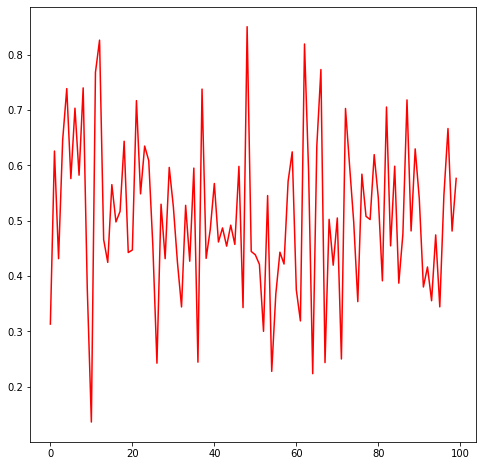

In [ ]:
import matplotlib.pyplot as plt
plt.plot(essg_df['rouge-1 f scores'],  color ="red")

In [ ]:
# rouge 2 f1 scores

essg_df['rouge-2 f scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-2']['f'])
essg_df['rouge-2 f scores'].mean()

0.3790613007030947

In [ ]:
# rouge l f1 scores

essg_df['rouge-l f scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-l']['f'])
essg_df['rouge-l f scores'].mean()

0.4882207081734482

In [ ]:
essg_df.to_pickle('essg_df_updated.pkl')

In [ ]:
essg_df = pd.read_pickle('/content/gdrive/MyDrive/summarisation_dataset/essg_df_updated.pkl')

In [ ]:
essg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   story                      100 non-null    object 
 1   summary                    100 non-null    object 
 2   filename                   100 non-null    object 
 3   original_sents             100 non-null    object 
 4   clean_sents                100 non-null    object 
 5   clean_para                 100 non-null    object 
 6   entities                   100 non-null    object 
 7   keywords                   100 non-null    object 
 8   combined_keywords          100 non-null    object 
 9   clean_sent_dict            100 non-null    object 
 10  reverse_cleanset           100 non-null    object 
 11  word_sentence_dictionary   100 non-null    object 
 12  dominating_set             100 non-null    object 
 13  mapp_dict                  100 non-null    object 


ROUGE 1 

In [ ]:
# RECALL
# rouge 1 r scores

essg_df['rouge-1 r scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-1']['r'])

print("Rouge-1 recall mean = ", end=" ")
print(essg_df['rouge-1 r scores'].mean())

print("Rouge-1 recall min = ", end=" ")
print(essg_df['rouge-1 r scores'].min())

print("Rouge-1 recall max = ", end=" ")
print(essg_df['rouge-1 r scores'].max())

Rouge-1 recall mean =  0.44363854448065054
Rouge-1 recall min =  0.09900990099009901
Rouge-1 recall max =  0.9615384615384616


In [ ]:
# PRECISION
# rouge 1 p scores

essg_df['rouge-1 p scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-1']['p'])

print("Rouge-1 precisoin mean = ", end=" ")
print(essg_df['rouge-1 p scores'].mean())

print("Rouge-1 precisoin min = ", end=" ")
print(essg_df['rouge-1 p scores'].min())

print("Rouge-1 precisoin max = ", end=" ")
print(essg_df['rouge-1 p scores'].max())

Rouge-1 precisoin mean =  0.6266647202969287
Rouge-1 precisoin min =  0.21739130434782608
Rouge-1 precisoin max =  0.9833333333333333


In [ ]:
# f 
# rouge 1 f scores

essg_df['rouge-1 f scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-1']['f'])

print("Rouge-1 f mean = ", end=" ")
print(essg_df['rouge-1 f scores'].mean())

print("Rouge-1 f min = ", end=" ")
print(essg_df['rouge-1 f scores'].min())

print("Rouge-1 f max = ", end=" ")
print(essg_df['rouge-1 f scores'].max())

Rouge-1 f mean =  0.5067681325548393
Rouge-1 f min =  0.13605441746864746
Rouge-1 f max =  0.8507462636745379


ROUGE 2

In [ ]:
# RECALL
# rouge 2 r scores

essg_df['rouge-2 r scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-2']['r'])

print("Rouge-2 recall mean = ", end=" ")
print(essg_df['rouge-2 r scores'].mean())

print("Rouge-2 recall min = ", end=" ")
print(essg_df['rouge-2 r scores'].min())

print("Rouge-2 recall max = ", end=" ")
print(essg_df['rouge-2 r scores'].max())

Rouge-2 recall mean =  0.3246169981647744
Rouge-2 recall min =  0.0
Rouge-2 recall max =  0.9428571428571428


In [ ]:
# PRECISION
# rouge 2 p scores

essg_df['rouge-2 p scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-2']['p'])

print("Rouge-2 PRECISION mean = ", end=" ")
print(essg_df['rouge-2 p scores'].mean())

print("Rouge-2 PRECISION min = ", end=" ")
print(essg_df['rouge-2 p scores'].min())

print("Rouge-2 PRECISION max = ", end=" ")
print(essg_df['rouge-2 p scores'].max())

Rouge-2 PRECISION mean =  0.495729857646681
Rouge-2 PRECISION min =  0.0
Rouge-2 PRECISION max =  0.9615384615384616


In [ ]:
# f score
# rouge 2 f scores

essg_df['rouge-2 f scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-2']['f'])

print("Rouge-2 f mean = ", end=" ")
print(essg_df['rouge-2 f scores'].mean())

print("Rouge-2 f min = ", end=" ")
print(essg_df['rouge-2 f scores'].min())

print("Rouge-2 f max = ", end=" ")
print(essg_df['rouge-2 f scores'].max())

Rouge-2 f mean =  0.3790613007030947
Rouge-2 f min =  0.0
Rouge-2 f max =  0.8214285664462869


ROUGE L

In [ ]:
# RECALL
# rouge L r scores

essg_df['rouge-l r scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-l']['r'])

print("Rouge-L recall mean = ", end=" ")
print(essg_df['rouge-l r scores'].mean())

print("Rouge-L recall min = ", end=" ")
print(essg_df['rouge-l r scores'].min())

print("Rouge-L recall max = ", end=" ")
print(essg_df['rouge-l r scores'].max())

Rouge-L recall mean =  0.4277089627008494
Rouge-L recall min =  0.06930693069306931
Rouge-L recall max =  0.9615384615384616


In [ ]:
# precesion
# rouge L p scores

essg_df['rouge-l p scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-l']['p'])

print("Rouge-L precesion mean = ", end=" ")
print(essg_df['rouge-l p scores'].mean())

print("Rouge-L precesion min = ", end=" ")
print(essg_df['rouge-l p scores'].min())

print("Rouge-L precesion max = ", end=" ")
print(essg_df['rouge-l p scores'].max())

Rouge-L precesion mean =  0.6032901485610926
Rouge-L precesion min =  0.14545454545454545
Rouge-L precesion max =  0.9833333333333333


In [ ]:
# f
# rouge L f scores

essg_df['rouge-l f scores'] = essg_df['rouge_values'].apply(lambda x: x['rouge-l']['f'])

print("Rouge-L f mean = ", end=" ")
print(essg_df['rouge-l f scores'].mean())

print("Rouge-L f min = ", end=" ")
print(essg_df['rouge-l f scores'].min())

print("Rouge-L f max = ", end=" ")
print(essg_df['rouge-l f scores'].max())

Rouge-L f mean =  0.4882207081734482
Rouge-L f min =  0.09523809093803527
Rouge-L f max =  0.8507462636745379


# CNN 

In [ ]:
import pickle

df_cnn = pd.read_pickle('/content/gdrive/MyDrive/summarisation_dataset/df_cnn_with_hypo_summaries.pkl')
df_cnn.head()

,story,highlights,filename,original_sents,clean_sents,clean_para,entities,keywords,combined_keywords,word_sentence_dictionary,dominating_set,hypo_summary,hypo_summary_para
0,"MOSCOW, Russia (CNN) -- Russian space official...",[Soyuz capsule lands hundreds of kilometers of...,00aa8e3ba59f5fe71a096a5549f80faece10aa83.story,"[MOSCOW, Russia CNN -- Russian space officials...","[MOSCOW , Russia CNN -- Russian space official...","MOSCOW , Russia CNN -- Russian space officials...","[Russian, Peggy Whitson Russian, Valery Lyndin...","[Earth, South, Soyuz, Russian, Korean, MOSCOW,...","[Russian, Malenchenko, Peggy Whitson Russian, ...","{'Russian': ['MOSCOW , Russia CNN -- Russian s...","[1, 7, 8, 9, 10]",[A South Korean bioengineer was one of three p...,A South Korean bioengineer was one of three pe...
1,"BEIJING, China (CNN) -- The head of China's qu...",[Head of China's quality watchdog resigns over...,00ae31ff5ede1de6cd39eccf36bae935c882527b.story,"[BEIJING, China CNN -- The head of China s qua...","[BEIJING , China CNN -- The head China quality...","BEIJING , China CNN -- The head China quality ...","[WHO, Shanghai, Wen Jiabao, Beijing, hours, AP...","[China, melamine, milk, Monday, dairy, Health,...","[products, WHO, Shanghai, Wen Jiabao, Beijing,...",{'products': ['China Health Ministry said Sund...,"[0, 4, 6, 12, 16, 17, 19, 20, 23, 24, 25, 27, ...","[BEIJING, China CNN -- The head of China s qua...","BEIJING, China CNN -- The head of China s qual..."
2,(CNN) -- Two of Turkey's main political partie...,[Turkey's ruling party agrees to lift ban on h...,00a570272e671a8fad94ffe0927a04c1bfc4110e.story,[CNN -- Two of Turkey s main political parties...,[CNN -- Two Turkey main political parties push...,CNN -- Two Turkey main political parties pushi...,"[coming days, Tuesday, early 1980s, Deniz Bayk...","[Turkey, secular, higher, commission, educatio...","[coming days, education, concern, Tuesday, sec...",{'coming days': ['The constitutional commissio...,"[0, 1, 4, 9, 10, 11, 13, 14, 15]",[CNN -- Two of Turkey s main political parties...,CNN -- Two of Turkey s main political parties ...
3,"ATLANTA, Georgia (CNN) -- Dressed head to toe...",[Designer Isaac Mizrahi moving from Target to ...,00a39c134080b6f215a81c15d46c3ac7cc7bdcf3.story,"[ATLANTA, Georgia CNN -- Dressed head to toe ...","[ATLANTA , Georgia CNN -- Dressed head toe bla...","ATLANTA , Georgia CNN -- Dressed head toe blac...","[Mizrahi, Georgia, every day, Isaac Mizrahi, d...","[Mizrahi, CNN, fashion, people, Isaac, ATLANTA...","[Mizrahi, Isaac, designer, people, Georgia, ev...","{'Isaac': ['ATLANTA , Georgia CNN -- Dressed h...","[1, 4, 8, 13, 15, 19, 23, 27, 28, 29, 30, 33, ...",[Isaac Mizrahi has earned four awards from the...,Isaac Mizrahi has earned four awards from the ...
4,"Clarksburg, West Virginia (CNN) -- North Cent...",[North Central West Virginia airport offers fr...,00aee24828cbceb3857579c59c9a85f381e358a5.story,"[Clarksburg, West Virginia CNN -- North Centr...","[Clarksburg , West Virginia CNN -- North Centr...","Clarksburg , West Virginia CNN -- North Centra...","[Altoona, Boeing, 15, 757, 20, 10,000, Christm...","[West, Virginia, Clarksburg, Coburn, Airport, ...","[Altoona, Boeing, 15, 757, 20, 10,000, Christm...","{'Altoona': ['In Altoona , Pennsylvania , resi...","[1, 2, 3, 5, 7, 16, 20]","[That s not surprising, considering that fewer...","That s not surprising, considering that fewer ..."


In [ ]:
df_cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   story                     25 non-null     object
 1   highlights                25 non-null     object
 2   filename                  25 non-null     object
 3   original_sents            25 non-null     object
 4   clean_sents               25 non-null     object
 5   clean_para                25 non-null     object
 6   entities                  25 non-null     object
 7   keywords                  25 non-null     object
 8   combined_keywords         25 non-null     object
 9   word_sentence_dictionary  25 non-null     object
 10  dominating_set            25 non-null     object
 11  hypo_summary              25 non-null     object
 12  hypo_summary_para         25 non-null     object
dtypes: object(13)
memory usage: 2.7+ KB


In [ ]:
# drop columns

df_cnn = df_cnn.drop(['word_sentence_dictionary', 'dominating_set', 'hypo_summary', 'hypo_summary_para'], axis = 1) 

In [ ]:
# find clean_sent dict
# key = index of sent(int), value = sentence(str)

df_cnn['clean_sent_dict'] = df_cnn['clean_sents'].apply(find_clean_sent_dict)

In [ ]:
# reverse this dictionary

df_cnn['reverse_cleanset'] = df_cnn['clean_sent_dict'].apply(lambda x: {v:k for k,v in x.items()})

In [ ]:
# create word sentence dictionaries

df_cnn['word_sentence_dictionary'] = df_cnn.apply(lambda x: create_hypergraph(x.combined_keywords ,x.clean_sents, x.reverse_cleanset), axis = 1)

In [ ]:
# remove high frequency words from the dictionary 

df_cnn['word_sentence_dictionary'] = df_cnn['word_sentence_dictionary'].apply(remove_high_freq_edges)

In [ ]:
# remove keywords with empty lists from the dictionary

df_cnn['word_sentence_dictionary'] = df_cnn['word_sentence_dictionary'].apply(remove_keywords_with_empty_lists)

In [ ]:
# apply domination and return mapp dictionary 

# duc_df[['dominating_set', 'mapp_dict']] = duc_df.apply(lambda x: domination_row(x.word_sentence_dictionary), axis=1)

df_cnn['dominating_set'], df_cnn['mapp_dict'] = zip(*df_cnn['word_sentence_dictionary'].apply(domination_row))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# find reverse of mapp dict 

df_cnn['reverse_mapp'] = df_cnn['mapp_dict'].apply(lambda x: {v:k for k,v in x.items()})

In [ ]:
# find indices of sentences from the nodes in dominating list 

df_cnn['summary_sentences_indices'] = df_cnn.apply((lambda x: [x.reverse_mapp[i] for i in x.dominating_set]), axis=1)

In [ ]:
# find system summary 

df_cnn['hypo_summary'] = df_cnn.apply((lambda x: [x.original_sents[i] for i in x.summary_sentences_indices]), axis=1)

In [ ]:
# convert all hypothesized summaries into paragraphs 

df_cnn['hypo_summary_para'] = df_cnn['hypo_summary'].apply(lambda x: " ".join([str(w) for w in x]))

In [ ]:
df_cnn['hypo_summary_para'][0]

'Mission Control spokesman Valery Lyndin said the condition of the crew -- South Korean bioengineer Yi So-yeon, American astronaut Peggy Whitson and Russian flight engineer Yuri Malenchenko -- was satisfactory, though the three had been subjected to severe G-forces during the re-entry. In October, the Soyuz capsule landed 70 kilometers from the planned area because of a damaged control cable. E-mail to a friend   This is not the first time a spacecraft veered from its planned trajectory during landing. Interfax reported that the spacecraft s landing was rough.'

In [ ]:
df_cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   story                      25 non-null     object
 1   highlights                 25 non-null     object
 2   filename                   25 non-null     object
 3   original_sents             25 non-null     object
 4   clean_sents                25 non-null     object
 5   clean_para                 25 non-null     object
 6   entities                   25 non-null     object
 7   keywords                   25 non-null     object
 8   combined_keywords          25 non-null     object
 9   clean_sent_dict            25 non-null     object
 10  reverse_cleanset           25 non-null     object
 11  word_sentence_dictionary   25 non-null     object
 12  dominating_set             25 non-null     object
 13  mapp_dict                  25 non-null     object
 14  reverse_mapp

In [ ]:
df_cnn['ref_summary_para'] = df_cnn['highlights'].apply(lambda x: ". ".join([str(w) for w in x]))

In [ ]:
df_cnn['ref_summary_para'][0]

"Soyuz capsule lands hundreds of kilometers off-target. Capsule was carrying South Korea's first astronaut. Landing is second time Soyuz capsule has gone awry"

In [ ]:
df_cnn['highlights'][0]

['Soyuz capsule lands hundreds of kilometers off-target',
 "Capsule was carrying South Korea's first astronaut",
 'Landing is second time Soyuz capsule has gone awry']

In [ ]:
# clean reference summaries

df_cnn['ref_summary_para'] = df_cnn['ref_summary_para'].apply(lambda x: x.replace('[',''))  # remove '[' start
df_cnn['ref_summary_para'] = df_cnn['ref_summary_para'].apply(lambda x: x.replace(']',''))   # remove ']' end
df_cnn['ref_summary_para'] = df_cnn['ref_summary_para'].apply(lambda x: x.replace('.,','.'))  # convert '.,' to '.'
df_cnn['ref_summary_para'] = df_cnn['ref_summary_para'].apply(lambda x: re.sub('\n', '', x))  # remove '\n' and '\'  newton\'s 
# df1['ref_summary_para'] = df1['ref_summary_para'].apply(lambda x: x.replace(',', ''))  # remove commas 
df_cnn['ref_summary_para'] = df_cnn['ref_summary_para'].apply(lambda x: x.replace('(', ''))  # remove paranthesis
df_cnn['ref_summary_para'] = df_cnn['ref_summary_para'].apply(lambda x: x.replace(')', ''))  # remove paranthesis 

# df1['ref_summary_para'] = df1['ref_summary_para'].apply(lambda x: x.replace('''\''','')) # replace '\' by ''

In [ ]:
df_cnn['ref_summary_para'][]

SyntaxError: ignored

In [ ]:
from rouge import Rouge

rouge = Rouge()

# axis = 1
df_cnn['rouge_values'] = df_cnn.apply((lambda x: rouge.get_scores((x.hypo_summary_para).lower(), (x.ref_summary_para).lower() ,avg=True)), axis = 1)

In [ ]:
df_cnn.to_pickle("df_cnn_final.pkl")

ROUGE 1

In [ ]:
# RECALL
# rouge 1 r scores

df_cnn['rouge-1 r scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-1']['r'])

print("Rouge-1 recall mean = ", end=" ")
print(df_cnn['rouge-1 r scores'].mean())

print("Rouge-1 recall min = ", end=" ")
print(df_cnn['rouge-1 r scores'].min())

print("Rouge-1 recall max = ", end=" ")
print(df_cnn['rouge-1 r scores'].max())

Rouge-1 recall mean =  0.49154456187276657
Rouge-1 recall min =  0.22857142857142856
Rouge-1 recall max =  0.717391304347826


In [ ]:
# PRECISION
# rouge 1 p scores

df_cnn['rouge-1 p scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-1']['p'])

print("Rouge-1 precisoin mean = ", end=" ")
print(df_cnn['rouge-1 p scores'].mean())

print("Rouge-1 precisoin min = ", end=" ")
print(df_cnn['rouge-1 p scores'].min())

print("Rouge-1 precisoin max = ", end=" ")
print(df_cnn['rouge-1 p scores'].max())

Rouge-1 precisoin mean =  0.1384053479310473
Rouge-1 precisoin min =  0.05084745762711865
Rouge-1 precisoin max =  0.30973451327433627


In [ ]:
# f 
# rouge 1 f scores

df_cnn['rouge-1 f scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-1']['f'])

print("Rouge-1 f mean = ", end=" ")
print(df_cnn['rouge-1 f scores'].mean())

print("Rouge-1 f min = ", end=" ")
print(df_cnn['rouge-1 f scores'].min())

print("Rouge-1 f max = ", end=" ")
print(df_cnn['rouge-1 f scores'].max())

Rouge-1 f mean =  0.2081373857261287
Rouge-1 f min =  0.08866994850542363
Rouge-1 f max =  0.4294478485076593


ROUGE 2

In [ ]:
# RECALL
# rouge 2 r scores

df_cnn['rouge-2 r scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-2']['r'])

print("Rouge-2 recall mean = ", end=" ")
print(df_cnn['rouge-2 r scores'].mean())

print("Rouge-2 recall min = ", end=" ")
print(df_cnn['rouge-2 r scores'].min())

print("Rouge-2 recall max = ", end=" ")
print(df_cnn['rouge-2 r scores'].max())

Rouge-2 recall mean =  0.13220644417163607
Rouge-2 recall min =  0.025
Rouge-2 recall max =  0.3448275862068966


In [ ]:
# PRECISION
# rouge 2 p scores

df_cnn['rouge-2 p scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-2']['p'])

print("Rouge-2 PRECISION mean = ", end=" ")
print(df_cnn['rouge-2 p scores'].mean())

print("Rouge-2 PRECISION min = ", end=" ")
print(df_cnn['rouge-2 p scores'].min())

print("Rouge-2 PRECISION max = ", end=" ")
print(df_cnn['rouge-2 p scores'].max())

Rouge-2 PRECISION mean =  0.03190798107342237
Rouge-2 PRECISION min =  0.003067484662576687
Rouge-2 PRECISION max =  0.15384615384615385


In [ ]:
# f score
# rouge 2 f scores

df_cnn['rouge-2 f scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-2']['f'])

print("Rouge-2 f mean = ", end=" ")
print(df_cnn['rouge-2 f scores'].mean())

print("Rouge-2 f min = ", end=" ")
print(df_cnn['rouge-2 f scores'].min())

print("Rouge-2 f max = ", end=" ")
print(df_cnn['rouge-2 f scores'].max())

Rouge-2 f mean =  0.04918955218012365
Rouge-2 f min =  0.005464478927409693
Rouge-2 f max =  0.21276595318017213


ROUGE L

In [ ]:
# RECALL
# rouge L r scores

df_cnn['rouge-l r scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-l']['r'])

print("Rouge-L recall mean = ", end=" ")
print(df_cnn['rouge-l r scores'].mean())

print("Rouge-L recall min = ", end=" ")
print(df_cnn['rouge-l r scores'].min())

print("Rouge-L recall max = ", end=" ")
print(df_cnn['rouge-l r scores'].max())

Rouge-L recall mean =  0.4487952035609329
Rouge-L recall min =  0.2
Rouge-L recall max =  0.6666666666666666


In [ ]:
# precesion
# rouge L p scores

df_cnn['rouge-l p scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-l']['p'])

print("Rouge-L precesion mean = ", end=" ")
print(df_cnn['rouge-l p scores'].mean())

print("Rouge-L precesion min = ", end=" ")
print(df_cnn['rouge-l p scores'].min())

print("Rouge-L precesion max = ", end=" ")
print(df_cnn['rouge-l p scores'].max())

Rouge-L precesion mean =  0.12487876810172935
Rouge-L precesion min =  0.03954802259887006
Rouge-L precesion max =  0.2920353982300885


In [ ]:
# f
# rouge L f scores

df_cnn['rouge-l f scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-l']['f'])

print("Rouge-L f mean = ", end=" ")
print(df_cnn['rouge-l f scores'].mean())

print("Rouge-L f min = ", end=" ")
print(df_cnn['rouge-l f scores'].min())

print("Rouge-L f max = ", end=" ")
print(df_cnn['rouge-l f scores'].max())

Rouge-L f mean =  0.18853801603887238
Rouge-L f min =  0.0689655150078867
Rouge-L f max =  0.40490797120704586


In [ ]:
# avg of all rouge-1 f scores 

df_cnn['rouge-1 f scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-1']['f'])
df_cnn['rouge-1 f scores'].mean()

0.2081373857261287

In [ ]:
# avg of all rouge-2 f scores 

df_cnn['rouge-2 f scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-2']['f'])
df_cnn['rouge-2 f scores'].mean()

0.04918955218012365

In [ ]:
# avg of all rouge-l f scores 

df_cnn['rouge-l f scores'] = df_cnn['rouge_values'].apply(lambda x: x['rouge-l']['f'])
df_cnn['rouge-l f scores'].mean()

0.18853801603887238